In [29]:
# IMPORTING NECESSARY LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

**DATA COLLECTION**

In [30]:
# Load the CSV file into a DataFrame
import pandas as pd
# Read the Excel file into a pandas DataFrame
df1 = pd.read_csv('/content/PM10.csv')
df2 = pd.read_csv('/content/PM2.5.csv')
df3 = pd.read_csv('/content/O3.csv')
df4 = pd.read_csv('/content/NO2.csv')
df5 = pd.read_csv('/content/CO.csv')

# Read the filtered data for North Carolina from the CSV file
# Ensure the date column is consistent and parse dates
dfs = [df1, df2, df3, df4, df5]
for df in dfs:
    df['ds'] = pd.to_datetime(df['ds'], infer_datetime_format=True)

# Merge DataFrames on the 'ds' (date) column
df_filtered = df1.merge(df2, on='ds', how='outer', suffixes=('_PM10', '_PM2.5')) \
                 .merge(df3, on='ds', how='outer') \
                 .merge(df4, on='ds', how='outer') \
                 .merge(df5, on='ds', how='outer')

# Rename columns to reflect the pollutants
df_filtered.columns = ['Date', 'PM10', 'PM2.5', 'O3', 'NO2', 'CO']

# Save the combined DataFrame to a new CSV file
output_file = 'Combined_Seoul_Pollution_Data.csv'
df_filtered.to_csv(output_file, index=False)

print(f"Combined CSV saved")

Combined CSV saved


**DATA CLEANING FOR RAW POLLUTANTS**

In [31]:
# Count duplicate columns
duplicate_columns = df_filtered.columns[df_filtered.columns.duplicated()]
num_duplicates = len(duplicate_columns)
print(f"Number of duplicate columns: {num_duplicates}")
if num_duplicates > 0:
    print(f"Duplicate columns: {list(duplicate_columns)}")

# Remove duplicate columns
df_filtered = df_filtered.loc[:, ~df_filtered.columns.duplicated()]

print(df_filtered.columns)
print(df_filtered.shape)

Number of duplicate columns: 0
Index(['Date', 'PM10', 'PM2.5', 'O3', 'NO2', 'CO'], dtype='object')
(25907, 6)


**AQI CALCULATION**

In [32]:
# Define breakpoints for various pollutants (1-hour average where applicable)
breakpoints = {
    'O3': [ # Ozone: 1-hour average in ppm
        (0, 0.054, 0, 50),
        (0.055, 0.070, 51, 100),
        (0.071, 0.085, 101, 150),
        (0.086, 0.105, 151, 200),
        (0.106, 0.200, 201, 300),
        (0.201, float('inf'), 301, 500)
    ],
    'PM2.5': [ # PM2.5: 1-hour average in µg/m³
        (0, 35.4, 0, 50),
        (35.5, 75.4, 51, 100),
        (75.5, 150.4, 101, 150),
        (150.5, 250.4, 151, 200),
        (250.5, 350.4, 201, 300),
        (350.5, 500.4, 301, 400),
        (500.5, float('inf'), 401, 500)
    ],
    'PM10': [ # PM10: 1-hour average in µg/m³
        (0, 150, 0, 50),
        (151, 350, 51, 100),
        (351, 420, 101, 150),
        (421, 600, 151, 200),
        (601, 800, 201, 300),
        (801, 1000, 301, 400),
        (1001, float('inf'), 401, 500)
    ],
    'CO': [ # Carbon Monoxide: 1-hour average in ppm
        (0, 4.4, 0, 50),
        (4.5, 9.4, 51, 100),
        (9.5, 12.4, 101, 150),
        (12.5, 15.4, 151, 200),
        (15.5, 30.4, 201, 300),
        (30.5, 40.4, 301, 400),
        (40.5, float('inf'), 401, 500)
    ],
    'SO2': [ # Sulfur Dioxide: 1-hour average in ppb
        (0, 35, 0, 50),
        (36, 75, 51, 100),
        (76, 185, 101, 150),
        (186, 304, 151, 200),
        (305, 604, 201, 300),
        (605, 804, 301, 400),
        (805, float('inf'), 401, 500)
    ],
    'NO2': [ # Nitrogen Dioxide: 1-hour average in ppm
        (0, 0.053, 0, 50),
        (0.054, 0.100, 51, 100),
        (0.101, 0.360, 101, 150),
        (0.361, 0.649, 151, 200),
        (0.650, 1.249, 201, 300),
        (1.250, 1.649, 301, 400),
        (1.650, float('inf'), 401, 500)
    ]
}

In [33]:
# Function to calculate AQI for a given pollutant concentration (annual average)
def calculate_aqi_annual(concentration, breakpoints):
    for bp in breakpoints:
        C_low, C_high, I_low, I_high = bp
        if C_low <= concentration <= C_high:
            aqi = ((I_high - I_low) / (C_high - C_low)) * (concentration - C_low) + I_low
            return round(aqi)
    return None


In [34]:
# Function to determine level of concern based on AQI
def get_level_of_concern(aqi):
    if aqi is None:
        return "Unknown"
    elif 0 <= aqi <= 50:
        return "Good"
    elif 51 <= aqi <= 100:
        return "Moderate"
    elif 101 <= aqi <= 150:
        return "Unhealthy for Sensitive Groups"
    elif 151 <= aqi <= 200:
        return "Unhealthy"
    elif 201 <= aqi <= 300:
        return "Very Unhealthy"
    elif 301 <= aqi <= 500:
        return "Hazardous"
    else:
        return "Out of Range"

In [35]:
# Identify pollutants in the dataset
pollutants = df_filtered.columns.difference(['Date'])  # Assuming 'ds' is the date column

for pollutant in breakpoints:
    if pollutant in df_filtered.columns:
        aqi_column = f"{pollutant}_AQI"
        df_filtered[aqi_column] = df_filtered[pollutant].apply(lambda x: calculate_aqi_annual(x, breakpoints[pollutant]))
    else:
        print(f"Skipping '{pollutant}' as it is not found in the dataset.")

# List of pollutants to consider for overall AQI
pollutants_to_consider = [f"{pollutant}_AQI" for pollutant in pollutants if f"{pollutant}_AQI" in df_filtered.columns]

# Calculate the overall AQI as the highest AQI among the specified pollutants
df_filtered['Overall_AQI'] = df_filtered[pollutants_to_consider].max(axis=1, skipna=True)

# Determine the overall level of concern based on the overall AQI
df_filtered['Level_of_Concern'] = df_filtered['Overall_AQI'].apply(get_level_of_concern)

# Save the results back to a new CSV file including original data
output_path = 'us-aqi-result.csv'
df_filtered.to_csv(output_path, index=False)

print(f"CSV file with AQI levels saved successfully: {output_path}")

print("\nDataFrame columns:")
print(df_filtered.columns)

Skipping 'SO2' as it is not found in the dataset.
CSV file with AQI levels saved successfully: us-aqi-result.csv

DataFrame columns:
Index(['Date', 'PM10', 'PM2.5', 'O3', 'NO2', 'CO', 'O3_AQI', 'PM2.5_AQI',
       'PM10_AQI', 'CO_AQI', 'NO2_AQI', 'Overall_AQI', 'Level_of_Concern'],
      dtype='object')


**DATA CLEANING AFTER AQI PREDICTION**

In [36]:
# Check for null values in the entire dataset
null_counts = df_filtered.isnull().sum()
total_nulls = null_counts.sum()

# Print counts of null values for each column and the total number of null values
print("Null Value Counts:")
print("====================")
print(null_counts)
print(f"Total null values in the dataset: {total_nulls}")

# Drop any remaining null values if they exist
if total_nulls > 0:
    df_filtered = df_filtered.dropna()
    print("Null values were present and have been dropped.")
    print(df_filtered.info())
else:
    print("No null values found. No rows were dropped.")

# Print the DataFrame info to confirm the changes and ensure it is clean
print(df_filtered.shape)

Null Value Counts:
Date                 0
PM10                19
PM2.5               19
O3                  19
NO2                 19
CO                  21
O3_AQI              19
PM2.5_AQI           31
PM10_AQI            21
CO_AQI              21
NO2_AQI             19
Overall_AQI         19
Level_of_Concern     0
dtype: int64
Total null values in the dataset: 227
Null values were present and have been dropped.
<class 'pandas.core.frame.DataFrame'>
Index: 25873 entries, 0 to 25906
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              25873 non-null  datetime64[ns]
 1   PM10              25873 non-null  float64       
 2   PM2.5             25873 non-null  float64       
 3   O3                25873 non-null  float64       
 4   NO2               25873 non-null  float64       
 5   CO                25873 non-null  float64       
 6   O3_AQI            25873 non-null  float64 

**DATA DESCRIPTION**

In [37]:
# Display basic information about the dataset
print("df_filtered Dataset Information:")
print("====================")
print(df_filtered.info())

df_filtered Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Index: 25873 entries, 0 to 25906
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              25873 non-null  datetime64[ns]
 1   PM10              25873 non-null  float64       
 2   PM2.5             25873 non-null  float64       
 3   O3                25873 non-null  float64       
 4   NO2               25873 non-null  float64       
 5   CO                25873 non-null  float64       
 6   O3_AQI            25873 non-null  float64       
 7   PM2.5_AQI         25873 non-null  float64       
 8   PM10_AQI          25873 non-null  float64       
 9   CO_AQI            25873 non-null  float64       
 10  NO2_AQI           25873 non-null  float64       
 11  Overall_AQI       25873 non-null  float64       
 12  Level_of_Concern  25873 non-null  object        
dtypes: datetime64[ns](1), float64(11), object(1)
mem

In [38]:
# Display summary statistics for numerical columns
print("\n DF Summary Statistics:")
print("====================")
print(df_filtered.describe())


 DF Summary Statistics:
                                Date          PM10         PM2.5  \
count                          25873  25873.000000  25873.000000   
mean   2018-06-27 21:39:24.843659776     38.103158     22.956828   
min              2017-01-01 01:00:00      0.000000      0.000000   
25%              2017-09-27 17:00:00     21.000000     11.000000   
50%              2018-06-24 18:00:00     32.000000     18.000000   
75%              2019-03-30 21:00:00     48.000000     29.000000   
max              2019-12-31 23:00:00    516.000000    513.000000   
std                              NaN     27.431698     20.047253   

                 O3           NO2            CO        O3_AQI     PM2.5_AQI  \
count  25873.000000  25873.000000  25873.000000  25873.000000  25873.000000   
mean       0.024608      0.031691      0.582685     25.015924     31.597186   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.009000      0.019000      0.40000

**EXPLORATORY DATA ANALYSIS**

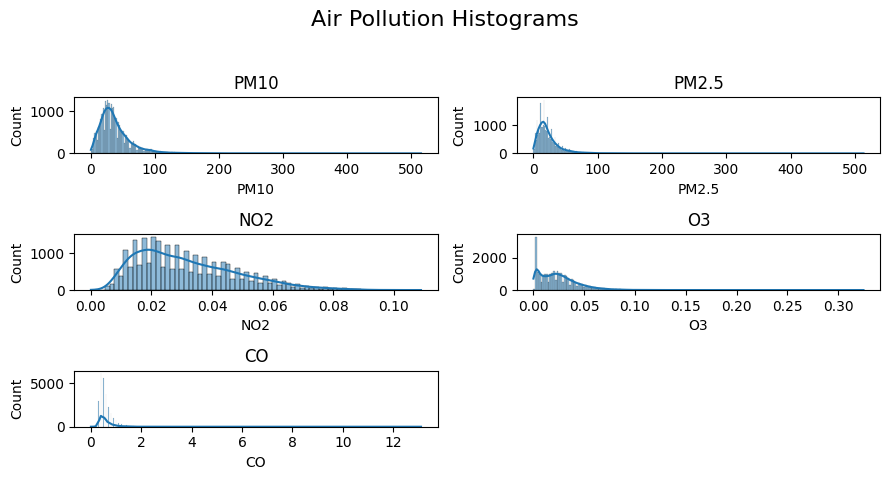

In [39]:
# Define the specific continuous variables to plot
specific_continuous = ['PM10', 'PM2.5', 'NO2', 'O3', 'CO']

# Ensure that the specified variables exist in the DataFrame
specific_continuous = [var for var in specific_continuous if var in df_filtered.columns]

# Number of variables and desired number of rows and columns
num_vars = len(specific_continuous)
num_rows = 5  # Desired number of rows
num_cols = 2  # Desired number of columns

# Calculate the number of rows required based on the number of variables and columns
num_rows = (num_vars + num_cols - 1) // num_cols

# Plot histograms for each specified continuous variable
fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(9, 5))  # Adjust figsize to be smaller

# Flatten the axes array for easier iteration
ax = ax.flatten()

# Use a for loop to plot the histogram for each variable
for variable, subplot in zip(specific_continuous, ax):
    # Use histplot() to plot the histogram
    sns.histplot(df_filtered[variable], ax=subplot, kde=True)
    subplot.set_title(variable)

# Hide any unused subplots if fewer variables than subplots
for i in range(len(specific_continuous), len(ax)):
    fig.delaxes(ax[i])

# Add an overall title for the entire plot
plt.suptitle('Air Pollution Histograms', fontsize=16)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Display the plot
plt.show()


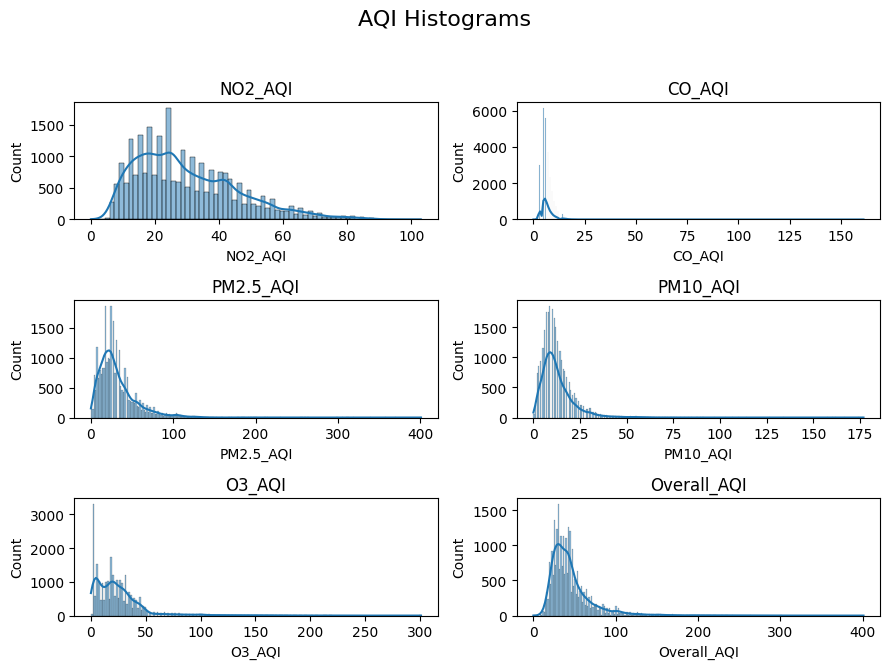

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the specific continuous variables to plot
specific_continuous = ['NO2_AQI', 'CO_AQI', 'PM2.5_AQI', 'PM10_AQI', 'O3_AQI', 'Overall_AQI']

# Ensure that the specified variables exist in the DataFrame
specific_continuous = [var for var in specific_continuous if var in df_filtered.columns]

# Number of variables and desired number of rows and columns
num_vars = len(specific_continuous)
num_cols = 2  # Desired number of columns

# Calculate the number of rows required based on the number of variables and columns
num_rows = (num_vars + num_cols - 1) // num_cols

# Plot histograms for each specified continuous variable
fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(9, 7))  # Adjust figsize to be larger

# Flatten the axes array for easier iteration
ax = ax.flatten()

# Use a for loop to plot the histogram for each variable
for variable, subplot in zip(specific_continuous, ax):
    # Use histplot() to plot the histogram
    sns.histplot(df_filtered[variable], ax=subplot, kde=True)
    subplot.set_title(variable)

# Hide any unused subplots if fewer variables than subplots
for i in range(len(specific_continuous), len(ax)):
    fig.delaxes(ax[i])

# Add an overall title for the entire plot
plt.suptitle('AQI Histograms', fontsize=16)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Display the plot
plt.show()


['Moderate' 'Unhealthy for Sensitive Groups' 'Good' 'Hazardous'
 'Unhealthy' 'Very Unhealthy']


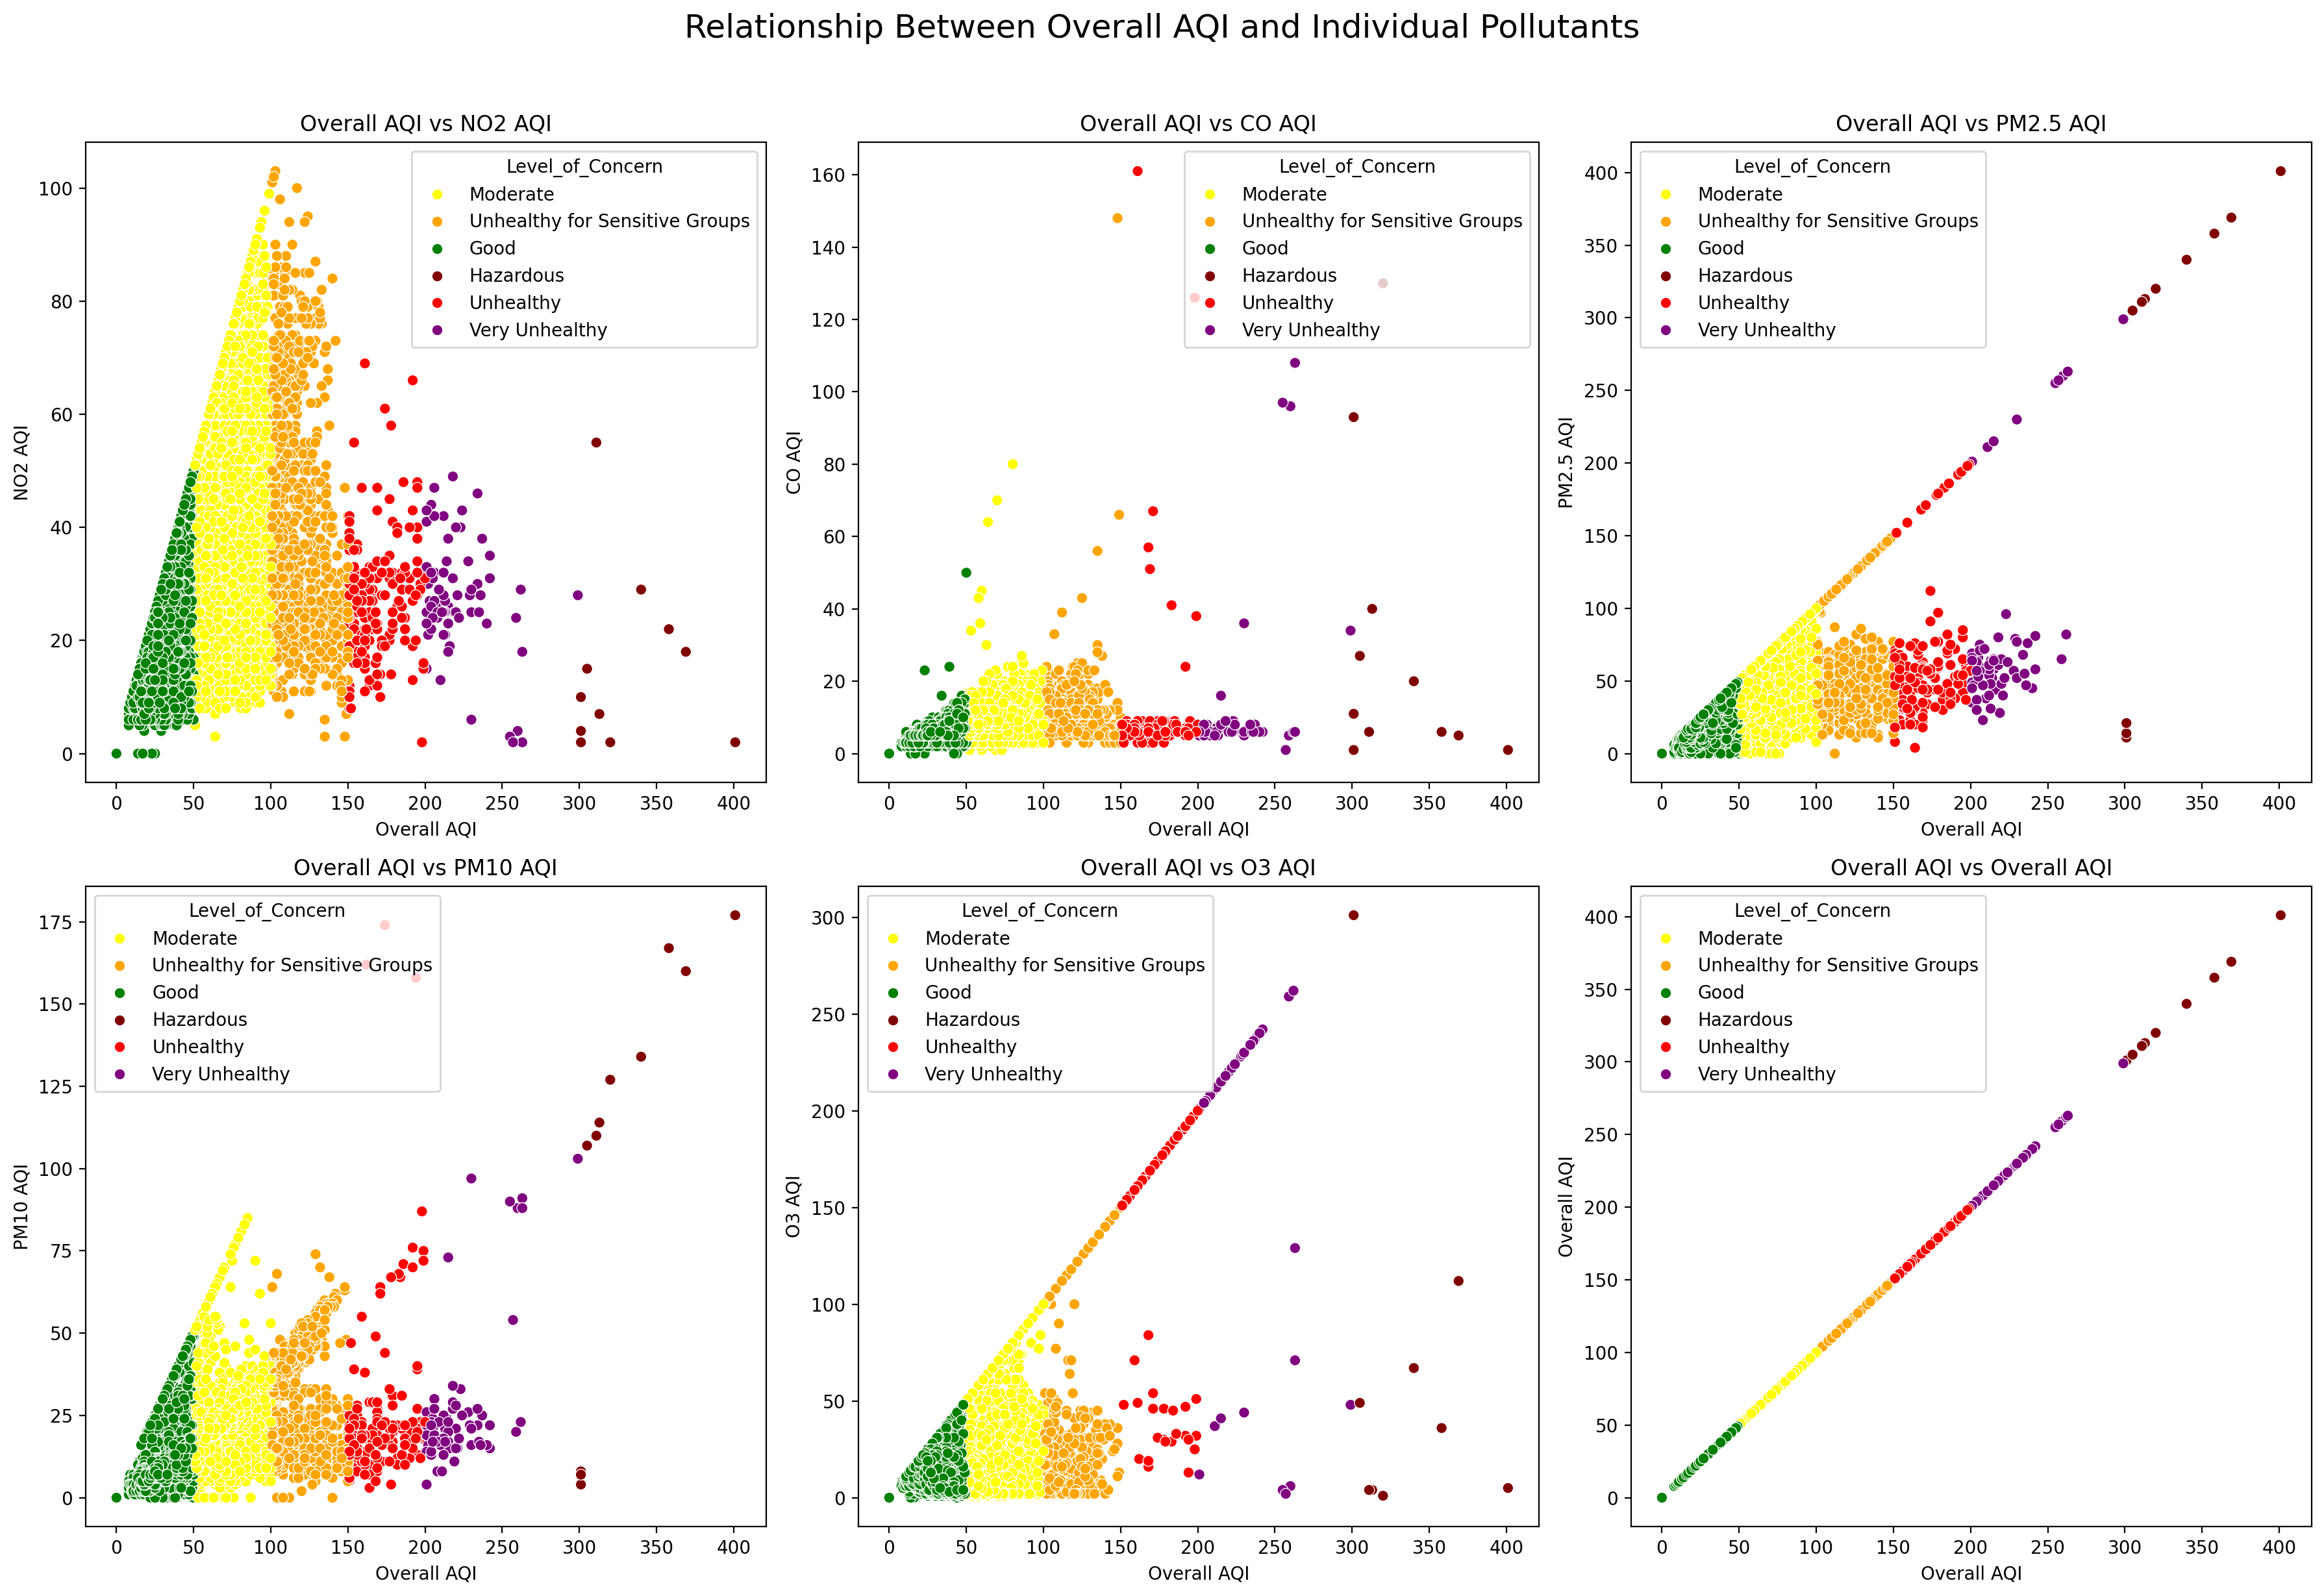

In [41]:
# Print unique levels of concern
print(df_filtered['Level_of_Concern'].unique())

# Define palette with updated color mapping
palette = {
    'Good': "green",
    'Moderate': "yellow",
    'Unhealthy for Sensitive Groups': "orange",
    'Unhealthy': "red",
    'Very Unhealthy': "purple",
    'Hazardous': "maroon"
}

# Create a figure with 6 subplots (2 rows, 3 columns)
fig, axs = plt.subplots(2, 3, figsize=(18, 12), dpi=200)

# Scatter plot 1: Overall AQI vs NO2 AQI
sns.scatterplot(x='Overall_AQI', y='NO2_AQI', data=df_filtered, hue='Level_of_Concern', palette=palette, ax=axs[0, 0])
axs[0, 0].set_xlabel('Overall AQI')
axs[0, 0].set_ylabel('NO2 AQI')
axs[0, 0].set_title('Overall AQI vs NO2 AQI')

# Scatter plot 2: Overall AQI vs CO AQI
sns.scatterplot(x='Overall_AQI', y='CO_AQI', data=df_filtered, hue='Level_of_Concern', palette=palette, ax=axs[0, 1])
axs[0, 1].set_xlabel('Overall AQI')
axs[0, 1].set_ylabel('CO AQI')
axs[0, 1].set_title('Overall AQI vs CO AQI')

# Scatter plot 3: Overall AQI vs PM2.5 AQI
sns.scatterplot(x='Overall_AQI', y='PM2.5_AQI', data=df_filtered, hue='Level_of_Concern', palette=palette, ax=axs[0, 2])
axs[0, 2].set_xlabel('Overall AQI')
axs[0, 2].set_ylabel('PM2.5 AQI')
axs[0, 2].set_title('Overall AQI vs PM2.5 AQI')

# Scatter plot 4: Overall AQI vs PM10 AQI
sns.scatterplot(x='Overall_AQI', y='PM10_AQI', data=df_filtered, hue='Level_of_Concern', palette=palette, ax=axs[1, 0])
axs[1, 0].set_xlabel('Overall AQI')
axs[1, 0].set_ylabel('PM10 AQI')
axs[1, 0].set_title('Overall AQI vs PM10 AQI')

# Scatter plot 5: Overall AQI vs O3 AQI
sns.scatterplot(x='Overall_AQI', y='O3_AQI', data=df_filtered, hue='Level_of_Concern', palette=palette, ax=axs[1, 1])
axs[1, 1].set_xlabel('Overall AQI')
axs[1, 1].set_ylabel('O3 AQI')
axs[1, 1].set_title('Overall AQI vs O3 AQI')

# Scatter plot 6: Overall AQI vs Overall AQI (self-comparison, just for completeness)
sns.scatterplot(x='Overall_AQI', y='Overall_AQI', data=df_filtered, hue='Level_of_Concern', palette=palette, ax=axs[1, 2])
axs[1, 2].set_xlabel('Overall AQI')
axs[1, 2].set_ylabel('Overall AQI')
axs[1, 2].set_title('Overall AQI vs Overall AQI')

# Add an overall title for the entire figure
plt.suptitle('Relationship Between Overall AQI and Individual Pollutants', fontsize=18, y=1.02)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


**ENCODING NON-NUMERIC TO NUMERIC**

In [42]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import warnings
import numpy as np
warnings.filterwarnings('ignore')

non_numeric_columns = df_filtered.select_dtypes(include=['object']).columns
numeric_columns = df_filtered.select_dtypes(include=[np.number]).columns
datetime_columns = df_filtered.select_dtypes(include=[np.datetime64]).columns

print("Non-Numeric Columns:")
print("====================")
print(non_numeric_columns)

print("Numeric Columns:")
print("================")
print(numeric_columns)

print("\nDatetime Columns:")
print("=================")
print(datetime_columns)

# Convert 'Date' column to datetime if it's not already
df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])

# Initialize the LabelEncoder
le = LabelEncoder()

# Apply LabelEncoder to each categorical column
for column in df_filtered.select_dtypes(include=['object']).columns:
    df_filtered[column] = le.fit_transform(df_filtered[column])

# Convert 'Date' column to timestamp in seconds
df_filtered['Date'] = df_filtered['Date'].view('int64') // 10**9  # Convert to seconds

# Check the result
print("Data types after label encoding:")
print(df_filtered.dtypes)

# Print a few rows to see the changes
print(df_filtered.head())

Non-Numeric Columns:
Index(['Level_of_Concern'], dtype='object')
Numeric Columns:
Index(['PM10', 'PM2.5', 'O3', 'NO2', 'CO', 'O3_AQI', 'PM2.5_AQI', 'PM10_AQI',
       'CO_AQI', 'NO2_AQI', 'Overall_AQI'],
      dtype='object')

Datetime Columns:
Index(['Date'], dtype='object')
Data types after label encoding:
Date                  int64
PM10                float64
PM2.5               float64
O3                  float64
NO2                 float64
CO                  float64
O3_AQI              float64
PM2.5_AQI           float64
PM10_AQI            float64
CO_AQI              float64
NO2_AQI             float64
Overall_AQI         float64
Level_of_Concern      int64
dtype: object
         Date  PM10  PM2.5     O3    NO2   CO  O3_AQI  PM2.5_AQI  PM10_AQI  \
0  1483272000  73.0   57.0  0.002  0.059  1.2     2.0       77.0      24.0   
1  1483272000  73.0   57.0  0.002  0.059  1.0     2.0       77.0      24.0   
2  1483272000  73.0   57.0  0.002  0.054  1.2     2.0       77.0      24.0   


**Select Features and Target Variable**

In [43]:
#Select features (X) and target (y)
X = df_filtered.drop(columns=['Overall_AQI'])  # Features
y = df_filtered['Overall_AQI']  # Target variable

In [44]:
# Print shapes of the resulting matrices
print("\nShapes of the matrices:")
print(f"X_shape: {X.shape}")
print(f"y_shape: {y.shape}")


Shapes of the matrices:
X_shape: (25873, 12)
y_shape: (25873,)


**STANDARDIZE THE FEATURE DATA**

In [45]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Apply the scaler to the feature data (X) and transform it
X_scaled = scaler.fit_transform(X)

# Convert the scaled features back to a DataFrame
# Using the original feature names from the DataFrame X
df_scaled_features = pd.DataFrame(data=X_scaled, columns=X.columns)

# Display the first 10 rows of the scaled feature DataFrame
df_scaled_features.head(10)

,Date,PM10,PM2.5,O3,NO2,CO,O3_AQI,PM2.5_AQI,PM10_AQI,CO_AQI,NO2_AQI,Level_of_Concern
0,-1.715286,1.27216,1.698179,-1.184056,1.645001,1.868249,-0.891009,1.918607,1.250723,1.953947,1.620199,1.259374
1,-1.715286,1.27216,1.698179,-1.184056,1.645001,1.262967,-0.891009,1.918607,1.250723,1.145334,1.620199,1.259374
2,-1.715286,1.27216,1.698179,-1.184056,1.343821,1.868249,-0.891009,1.918607,1.250723,1.953947,1.308372,1.259374
3,-1.715286,1.27216,1.698179,-1.184056,1.343821,1.262967,-0.891009,1.918607,1.250723,1.145334,1.308372,1.259374
4,-1.715286,1.27216,1.698179,-1.026936,1.645001,1.868249,-0.774871,1.918607,1.250723,1.953947,1.620199,1.259374
5,-1.715286,1.27216,1.698179,-1.026936,1.645001,1.262967,-0.774871,1.918607,1.250723,1.145334,1.620199,1.259374
6,-1.715286,1.27216,1.698179,-1.026936,1.343821,1.868249,-0.774871,1.918607,1.250723,1.953947,1.308372,1.259374
7,-1.715286,1.27216,1.698179,-1.026936,1.343821,1.262967,-0.774871,1.918607,1.250723,1.145334,1.308372,1.259374
8,-1.715286,1.27216,2.795608,-1.184056,1.645001,1.868249,-0.891009,3.017300,1.250723,1.953947,1.620199,3.091261
9,-1.715286,1.27216,2.795608,-1.184056,1.645001,1.262967,-0.891009,3.017300,1.250723,1.145334,1.620199,3.091261


**PCA - FEATURE SELECTION**

In [46]:
# Initialize the PCA model
pca = PCA()

# Fit the PCA model to the scaled feature data
pca.fit(df_scaled_features)

# Create a DataFrame for the loadings matrix
# Each row corresponds to a feature and each column to a principal component
loadings = pd.DataFrame(
    pca.components_.T,  # Transpose of the components matrix to align features with PCs
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],  # Principal component names
    index=df_scaled_features.columns  # Feature names
)

# Print the loadings matrix to view the relationship between features and principal components
print(loadings)


                       PC1       PC2       PC3       PC4       PC5       PC6  \
Date             -0.048652 -0.104795  0.773351  0.338375 -0.520020  0.049603   
PM10              0.346153  0.194004  0.178948 -0.292836  0.025624  0.381377   
PM2.5             0.358004  0.161266  0.177203 -0.198153  0.057151 -0.321365   
O3               -0.087247  0.561605 -0.094332  0.259656 -0.012432  0.247661   
NO2               0.309430 -0.257246 -0.332372  0.084110 -0.387390  0.209664   
CO                0.324763 -0.148268  0.073070  0.443627  0.398223  0.037262   
O3_AQI           -0.048179  0.553569 -0.156395  0.343705 -0.122608  0.158564   
PM2.5_AQI         0.368854  0.155027  0.119422 -0.180972 -0.009837 -0.300296   
PM10_AQI          0.346324  0.193569  0.174265 -0.296016  0.015136  0.381904   
CO_AQI            0.320982 -0.143844  0.072948  0.456350  0.409011  0.060434   
NO2_AQI           0.310189 -0.256423 -0.332122  0.085985 -0.385679  0.205742   
Level_of_Concern  0.288535  0.259671 -0.

In [47]:
# Compute the absolute sum of loadings for each feature across all principal components
# and sort them in descending order to identify the most contributing features

cumulative_contributions = loadings.abs().sum(axis=1).sort_values(ascending=False)

# Define the top features based on cumulative contributions
# Here we select all features but you can adjust to select a specific number (e.g., top 10)
top_features = cumulative_contributions.index[:]  # Example: Adjust to select top N features

# Print the cumulative contributions of all features
print("Cumulative Contributions of Features:")
print(cumulative_contributions)

# Print the selected top features
print("\nSelected Top Features Based on Cumulative Contribution:")
print(top_features)

Cumulative Contributions of Features:
PM2.5               2.573272
Level_of_Concern    2.570640
NO2_AQI             2.550822
PM10                2.532200
NO2                 2.529903
PM10_AQI            2.502532
PM2.5_AQI           2.400778
O3                  2.291960
O3_AQI              2.288382
CO_AQI              2.250577
CO                  2.219809
Date                1.884983
dtype: float64

Selected Top Features Based on Cumulative Contribution:
Index(['PM2.5', 'Level_of_Concern', 'NO2_AQI', 'PM10', 'NO2', 'PM10_AQI',
       'PM2.5_AQI', 'O3', 'O3_AQI', 'CO_AQI', 'CO', 'Date'],
      dtype='object')


In [48]:
# Define a threshold for selecting top features
threshold = 2  #Change the threshold for selecting number of features

# Identify the top features that meet or exceed the threshold
top_features = cumulative_contributions[cumulative_contributions >= threshold].index

# Display the selected top features
print("\nSelected top features based on threshold:")
print(top_features)

# Extract the columns corresponding to the selected top features from the dataset
X_top_features = df_filtered[top_features]

# Print the shape of the dataset with top features
print(X_top_features.shape)


Selected top features based on threshold:
Index(['PM2.5', 'Level_of_Concern', 'NO2_AQI', 'PM10', 'NO2', 'PM10_AQI',
       'PM2.5_AQI', 'O3', 'O3_AQI', 'CO_AQI', 'CO'],
      dtype='object')
(25873, 11)


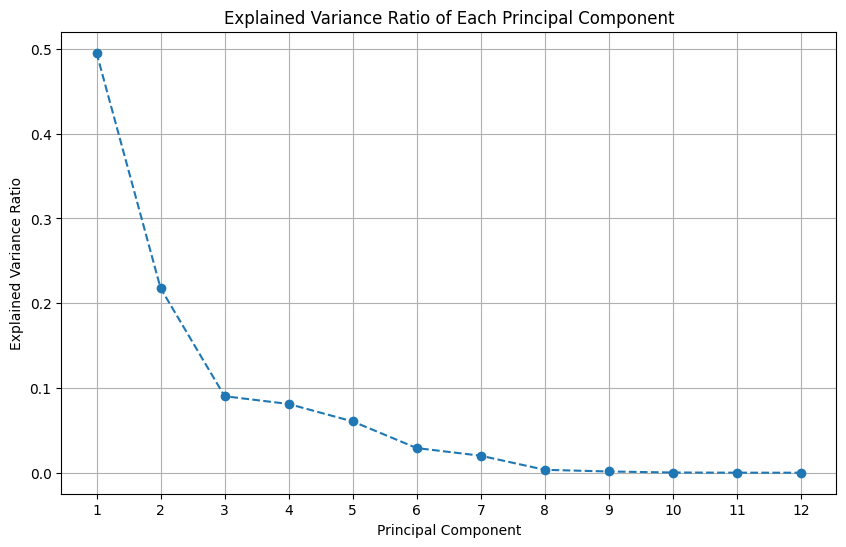

In [49]:
# Get the explained variance ratios
explained_variance_ratio = pca.explained_variance_ratio_

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.title('Explained Variance Ratio of Each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(np.arange(1, len(explained_variance_ratio) + 1))
plt.grid(True)
plt.show()


**SPLITTNG THE DATASET TO TRAIN AND TEST**

In [50]:
# Split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X_top_features, y, test_size=0.3,random_state=42)

# Print shapes of the resulting matrices
print("\nShapes of the matrices:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


Shapes of the matrices:
X_train shape: (18111, 11)
X_test shape: (7762, 11)
y_train shape: (18111,)
y_test shape: (7762,)


#RF REGRESSION

In [51]:
# Initialize the Random Forest Regressor model with specified hyperparameters
rf_model_seoul = RandomForestRegressor(
    n_estimators=100,          # Number of trees in the forest
    max_depth=3,               # Maximum depth of each tree to prevent overfitting
    min_samples_split=10,      # Minimum number of samples required to split an internal node
    min_samples_leaf=5,        # Minimum number of samples required at each leaf node
    random_state=42         # Seed for reproducibility
)

# Train the Random Forest model on the training data
rf_model_seoul.fit(X_train, y_train)

# Predict target values on the training set
y_train_predictions = rf_model_seoul.predict(X_train)

# Predict target values on the test set
y_test_predictions = rf_model_seoul.predict(X_test)


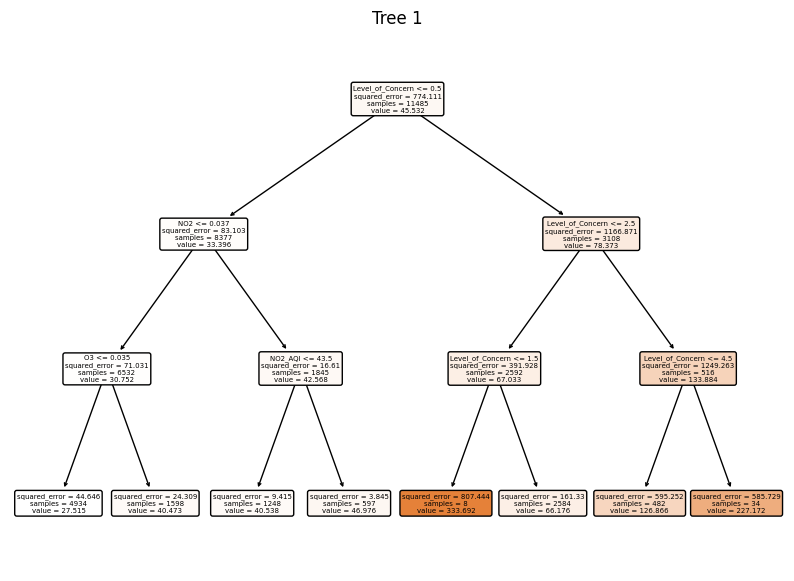

In [52]:
# Function to plot the structure of a decision tree
def plot_tree_structure(tree, feature_names, tree_index):
    plt.figure(figsize=(10, 7))
    plot_tree(
        tree,
        feature_names=feature_names,
        filled=True,
        rounded=True
    )
    plt.title(f'Tree {tree_index + 1}')
    plt.show()

# Plot details for the first few trees
feature_names = X_train.columns
for i, tree in enumerate(rf_model_seoul.estimators_[:1]):  # Plot details for the first 2 trees
    plot_tree_structure(tree, feature_names, i)

**Evaluate Model Performance**

In [53]:
# Compute evaluation metrics for the training set
train_mse = mean_squared_error(y_train, y_train_predictions)
train_rmse = mean_squared_error(y_train, y_train_predictions, squared=False)
train_mae = mean_absolute_error(y_train, y_train_predictions)
train_r2 = r2_score(y_train, y_train_predictions)

# Compute evaluation metrics for the test set
test_mse = mean_squared_error(y_test, y_test_predictions)
test_rmse = mean_squared_error(y_test, y_test_predictions, squared=False)
test_mae = mean_absolute_error(y_test, y_test_predictions)
test_r2 = r2_score(y_test, y_test_predictions)

In [54]:
# Create a DataFrame to display results in a table format
print("Seoul RF model metrics" )
results = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R2'],
    'Training Set': [train_mse, train_rmse, train_mae, train_r2],
    'Test Set': [test_mse, test_rmse, test_mae, test_r2]
})

print(results)

Seoul RF model metrics
  Metric  Training Set   Test Set
0    MSE     77.416526  76.759316
1   RMSE      8.798666   8.761239
2    MAE      6.105144   6.180203
3     R2      0.894929   0.887250


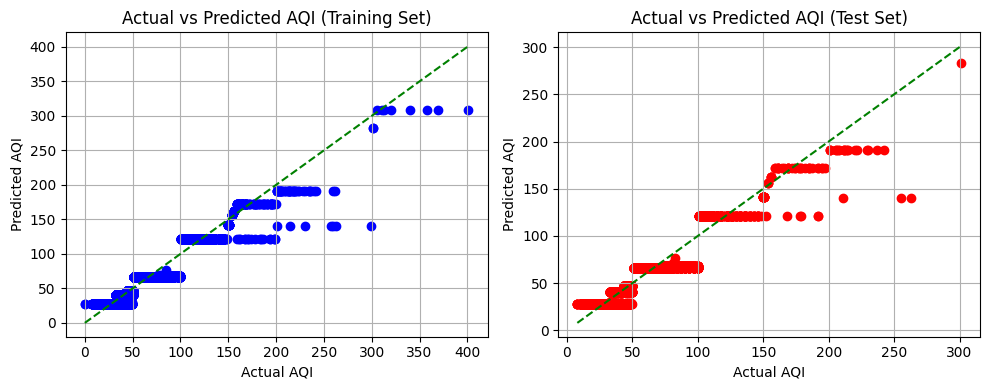

In [55]:
# Create a figure with two subplots side by side
plt.figure(figsize=(10, 4))  # Adjust the figure size as needed

# Plot for the training set
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_predictions, color='blue')
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.title('Actual vs Predicted AQI (Training Set)')
plt.grid(True)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'g--')  # Reference line

# Plot for the test set
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_predictions, color='red')
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.title('Actual vs Predicted AQI (Test Set)')
plt.grid(True)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'g--')  # Reference line

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


**CROSS VALDATION**

In [56]:
# Perform cross-validation for negative mean squared error (MSE)
cv_mse_scores = cross_val_score(rf_model_seoul, X_top_features, y, cv=5, scoring='neg_mean_squared_error')

# Convert negative MSE to positive and calculate mean and RMSE
cv_mse = -cv_mse_scores.mean()
cv_rmse = np.sqrt(cv_mse)

# Perform cross-validation for R-squared (R²)
cv_r2_scores = cross_val_score(rf_model_seoul, X_top_features, y, cv=5, scoring='r2')

# Calculate mean R²
cv_r2 = cv_r2_scores.mean()

print(f'Cross-Validation Mean Squared Error (MSE): {cv_mse}')
print(f'Cross-Validation Root Mean Squared Error (RMSE): {cv_rmse}')
print(f'Cross-Validation R-squared (R²): {cv_r2}')


Cross-Validation Mean Squared Error (MSE): 86.7323651306501
Cross-Validation Root Mean Squared Error (RMSE): 9.313021267593568
Cross-Validation R-squared (R²): 0.8645245627814298


In [57]:
def compare_y_test_y_pred(y_test, y_predicted):

  comparison_df = pd.DataFrame({'actual': y_test, 'predicted': y_predicted})
  comparison_df['error'] = comparison_df['predicted'] - comparison_df['actual']
  return comparison_df

comparison_df_rf = compare_y_test_y_pred(y_test, y_test_predictions)
print(comparison_df_rf)

       actual  predicted      error
196      63.0  66.236353   3.236353
14441    48.0  40.410375  -7.589625
16532    42.0  41.095277  -0.904723
13719    40.0  27.530928 -12.469072
24116    54.0  66.236353  12.236353
...       ...        ...        ...
24396    31.0  27.530928  -3.469072
20437    48.0  40.187087  -7.812913
15946    16.0  27.530928  11.530928
23702    44.0  40.362364  -3.637636
6007     67.0  66.236353  -0.763647

[7762 rows x 3 columns]


Text(0.5, 1.0, 'Error Distribution')

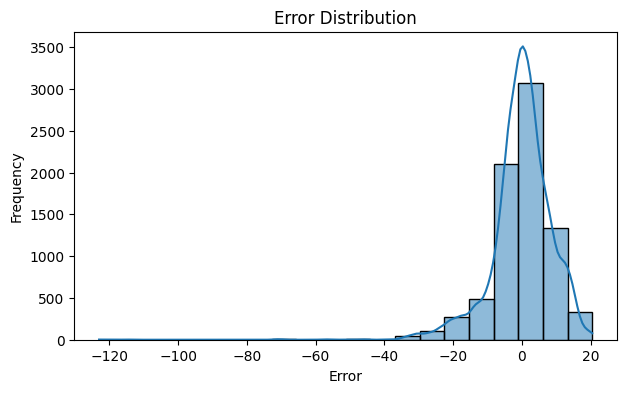

In [58]:
# 2. Error Distribution
plt.figure(figsize=(7, 4))
sns.histplot(comparison_df_rf['error'], bins=20, kde=True)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Error Distribution')



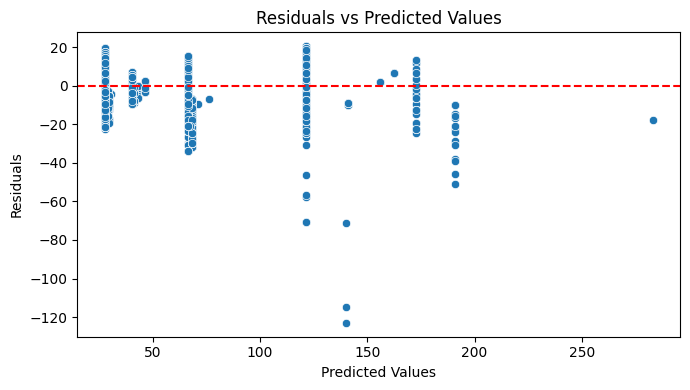

In [59]:
# 3. Residual Plot
plt.figure(figsize=(7, 4))
sns.scatterplot(x=comparison_df_rf['predicted'], y=comparison_df_rf['error'])
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.axhline(y=0, color='r', linestyle='--')

plt.tight_layout()
plt.show()

# SUPPORT VECTOR REGRESSION

In [60]:
# Create the SVR model with the linear kernel
svr_linear_seoul = SVR(kernel='linear', C=0.00001, epsilon=12)

# Train the model
svr_linear_seoul.fit(X_train, y_train)

# Make predictions
y_train_pred_linear = svr_linear_seoul.predict(X_train)
y_test_pred_linear = svr_linear_seoul.predict(X_test)

In [61]:
# Evaluate the model
train_mse_linear = mean_squared_error(y_train, y_train_pred_linear)
train_rmse_linear = mean_squared_error(y_train, y_train_pred_linear, squared=False)
train_mae_linear = mean_absolute_error(y_train, y_train_pred_linear)
train_r2_linear = r2_score(y_train, y_train_pred_linear)

test_mse_linear = mean_squared_error(y_test, y_test_pred_linear)
test_rmse_linear = mean_squared_error(y_test, y_test_pred_linear, squared=False)
test_mae_linear = mean_absolute_error(y_test, y_test_pred_linear)
test_r2_linear = r2_score(y_test, y_test_pred_linear)

In [62]:
print("SVR with Linear Kernel")
results_linear = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R2'],
    'Training Set': [train_mse_linear, train_rmse_linear, train_mae_linear, train_r2_linear],
    'Test Set': [test_mse_linear, test_rmse_linear, test_mae_linear, test_r2_linear]
})
print(results_linear)

SVR with Linear Kernel
  Metric  Training Set    Test Set
0    MSE    138.403773  133.562141
1   RMSE     11.764513   11.556909
2    MAE      8.142368    8.157625
3     R2      0.812156    0.803813


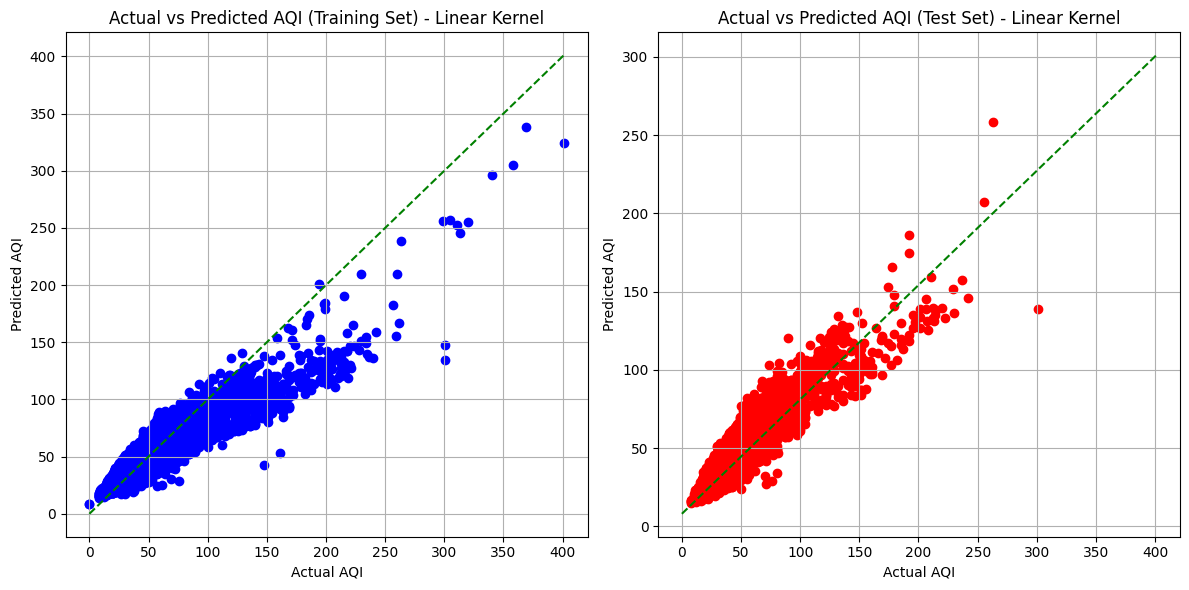

In [63]:
# Plot actual vs predicted AQI values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred_linear, color='blue')
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.title('Actual vs Predicted AQI (Training Set) - Linear Kernel')
plt.grid(True)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'g--')  # Reference line


plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred_linear, color='red')
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.title('Actual vs Predicted AQI (Test Set) - Linear Kernel')
plt.grid(True)
plt.plot([y_train.min(), y_train.max()], [y_test.min(), y_test.max()], 'g--')  # Reference line


plt.tight_layout()
plt.show()

In [64]:
def compare_y_test_y_pred(y_test, y_predicted):

  comparison_df = pd.DataFrame({'actual': y_test, 'predicted': y_predicted})
  comparison_df['error'] = comparison_df['predicted'] - comparison_df['actual']
  return comparison_df

comparison_df_linear = compare_y_test_y_pred(y_test, y_test_pred_linear)
print(comparison_df_linear)

       actual  predicted      error
196      63.0  59.032634  -3.967366
14441    48.0  46.953404  -1.046596
16532    42.0  40.114798  -1.885202
13719    40.0  51.588735  11.588735
24116    54.0  40.029747 -13.970253
...       ...        ...        ...
24396    31.0  44.715312  13.715312
20437    48.0  65.809633  17.809633
15946    16.0  25.464861   9.464861
23702    44.0  56.563491  12.563491
6007     67.0  59.459767  -7.540233

[7762 rows x 3 columns]


Text(0.5, 1.0, 'Error Distribution')

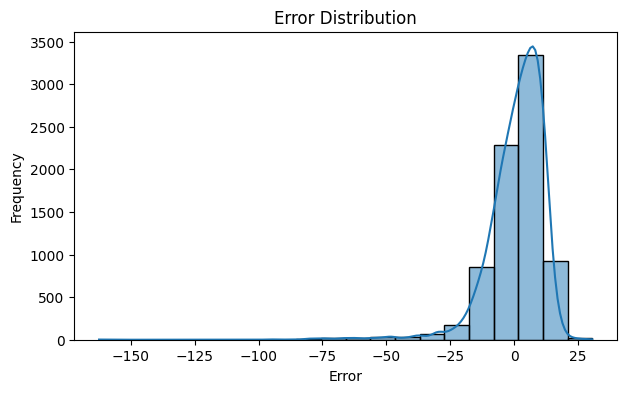

In [65]:
# 2. Error Distribution
plt.figure(figsize=(7, 4))
sns.histplot(comparison_df_linear['error'], bins=20, kde=True)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Error Distribution')

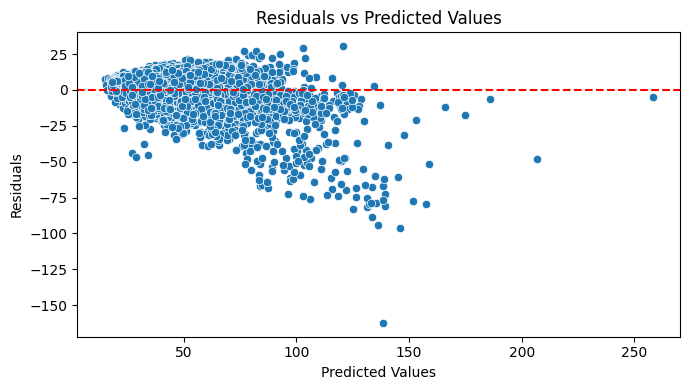

In [66]:
# 3. Residual Plot
plt.figure(figsize=(7, 4))
sns.scatterplot(x=comparison_df_linear['predicted'], y=comparison_df_linear['error'])
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.axhline(y=0, color='r', linestyle='--')

plt.tight_layout()
plt.show()

In [67]:
# Define custom scoring functions
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

# Perform cross-validation for MSE
cv_scores_mse = cross_val_score(svr_linear_seoul, X_top_features, y, cv=5, scoring=mse_scorer)
cv_mse = -cv_scores_mse.mean()
cv_rmse = np.sqrt(cv_mse)

# Perform cross-validation for R²
cv_scores_r2 = cross_val_score(svr_linear_seoul, X_top_features, y, cv=5, scoring=r2_scorer)
cv_r2 = cv_scores_r2.mean()

# Print results
print("Cross-Validation Results for SVR with Linear Kernel")
print(f"Mean Squared Error (MSE): {cv_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {cv_rmse:.4f}")
print(f"R² Score: {cv_r2:.4f}")


Cross-Validation Results for SVR with Linear Kernel
Mean Squared Error (MSE): 142.7557
Root Mean Squared Error (RMSE): 11.9480
R² Score: 0.7994


**SVR - POLY KERNEL**

In [68]:
# Create the SVR model with the polynomial kernel
svr_poly_seoul = SVR(kernel='poly', degree=2)

# Train the model
svr_poly_seoul.fit(X_train, y_train)

# Make predictions
y_train_pred_poly = svr_poly_seoul.predict(X_train)
y_test_pred_poly = svr_poly_seoul.predict(X_test)

In [69]:
# Evaluate the model
train_mse_poly = mean_squared_error(y_train, y_train_pred_poly)
train_rmse_poly = mean_squared_error(y_train, y_train_pred_poly, squared=False)
train_mae_poly = mean_absolute_error(y_train, y_train_pred_poly)
train_r2_poly = r2_score(y_train, y_train_pred_poly)

test_mse_poly = mean_squared_error(y_test, y_test_pred_poly)
test_rmse_poly = mean_squared_error(y_test, y_test_pred_poly, squared=False)
test_mae_poly = mean_absolute_error(y_test, y_test_pred_poly)
test_r2_poly = r2_score(y_test, y_test_pred_poly)

In [70]:
# Print results
print("SVR with Polynomial Kernel")
results_poly = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R2'],
    'Training Set': [train_mse_poly, train_rmse_poly, train_mae_poly, train_r2_poly],
    'Test Set': [test_mse_poly, test_rmse_poly, test_mae_poly, test_r2_poly]
})
print(results_poly)

SVR with Polynomial Kernel
  Metric  Training Set   Test Set
0    MSE     68.484194  65.400629
1   RMSE      8.275518   8.087066
2    MAE      4.538226   4.630289
3     R2      0.907052   0.903934


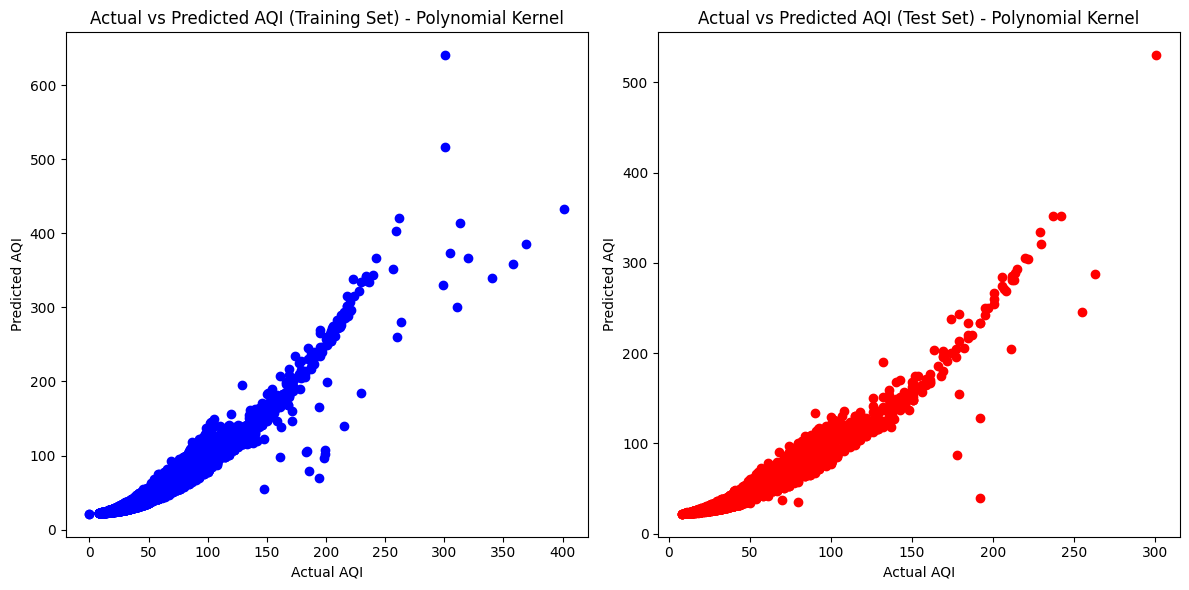

In [71]:
# Plot actual vs predicted AQI values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred_poly, color='blue')
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.title('Actual vs Predicted AQI (Training Set) - Polynomial Kernel')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred_poly, color='red')
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.title('Actual vs Predicted AQI (Test Set) - Polynomial Kernel')

plt.tight_layout()
plt.show()

In [72]:
def compare_y_test_y_pred(y_test, y_predicted):

  comparison_df = pd.DataFrame({'actual': y_test, 'predicted': y_test_pred_poly})
  comparison_df['error'] = comparison_df['predicted'] - comparison_df['actual']
  return comparison_df

comparison_df_poly = compare_y_test_y_pred(y_test, y_test_pred_poly)
print(comparison_df_poly)

       actual  predicted      error
196      63.0  68.080628   5.080628
14441    48.0  38.028399  -9.971601
16532    42.0  38.636187  -3.363813
13719    40.0  40.299545   0.299545
24116    54.0  50.783726  -3.216274
...       ...        ...        ...
24396    31.0  34.460638   3.460638
20437    48.0  51.541390   3.541390
15946    16.0  24.345971   8.345971
23702    44.0  44.894840   0.894840
6007     67.0  52.838296 -14.161704

[7762 rows x 3 columns]


Text(0.5, 1.0, 'Error Distribution')

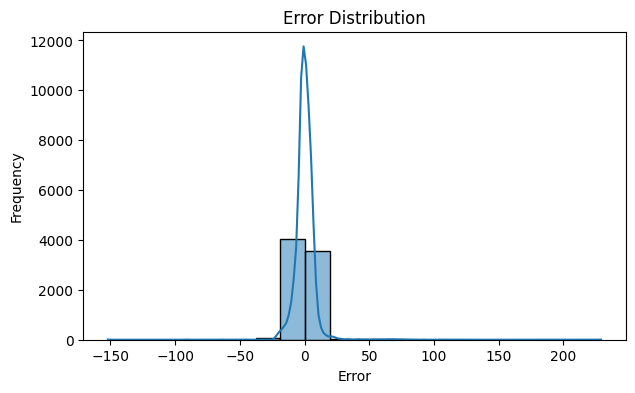

In [73]:
# 2. Error Distribution
plt.figure(figsize=(7, 4))
sns.histplot(comparison_df_poly['error'], bins=20, kde=True)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Error Distribution')



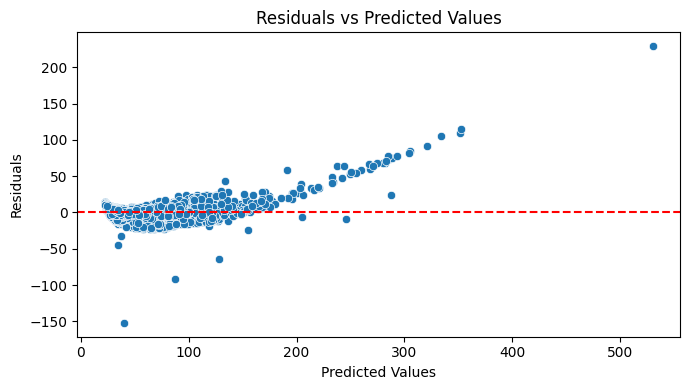

In [74]:
# 3. Residual Plot
plt.figure(figsize=(7, 4))
sns.scatterplot(x=comparison_df_poly['predicted'], y=comparison_df_poly['error'])
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.axhline(y=0, color='r', linestyle='--')

plt.tight_layout()
plt.show()

In [75]:
# Define custom scoring functions
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

# Perform cross-validation for MSE
cv_scores_poly_mse = cross_val_score(svr_poly_seoul, X_top_features, y, cv=5, scoring=mse_scorer)
cv_mse_poly = -cv_scores_poly_mse.mean()
cv_rmse_poly = np.sqrt(cv_mse_poly)

# Perform cross-validation for R^2
cv_scores_poly_r2 = cross_val_score(svr_poly_seoul, X_top_features, y, cv=5, scoring=r2_scorer)
cv_r2_poly = cv_scores_poly_r2.mean()

print("Cross-Validation Results for SVR with Polynomial Kernel")
print(f"Mean Squared Error (MSE): {cv_mse_poly}")
print(f"Root Mean Squared Error (RMSE): {cv_rmse_poly}")
print(f"R^2 Score: {cv_r2_poly}")


Cross-Validation Results for SVR with Polynomial Kernel
Mean Squared Error (MSE): 82.67503091690114
Root Mean Squared Error (RMSE): 9.092581092126764
R^2 Score: 0.8850381160675382


**SVR - RBF KERNEL**

In [76]:
# Create the SVR model with the RBF kernel
svr_rbf_seoul = SVR(kernel='rbf', C=0.1, gamma='scale') # Adjust C and gamma if needed

# Train the model
svr_rbf_seoul.fit(X_train, y_train)

# Make predictions
y_train_pred_rbf = svr_rbf_seoul.predict(X_train)
y_test_pred_rbf = svr_rbf_seoul.predict(X_test)

In [77]:
# Evaluate the model
train_mse_rbf = mean_squared_error(y_train, y_train_pred_rbf)
train_rmse_rbf = mean_squared_error(y_train, y_train_pred_rbf, squared=False)
train_mae_rbf = mean_absolute_error(y_train, y_train_pred_rbf)
train_r2_rbf = r2_score(y_train, y_train_pred_rbf)

test_mse_rbf = mean_squared_error(y_test, y_test_pred_rbf)
test_rmse_rbf = mean_squared_error(y_test, y_test_pred_rbf, squared=False)
test_mae_rbf = mean_absolute_error(y_test, y_test_pred_rbf)
test_r2_rbf = r2_score(y_test, y_test_pred_rbf)


In [78]:
# Print results
print("SVR with RBF Kernel")
results_rbf = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R2'],
    'Training Set': [train_mse_rbf, train_rmse_rbf, train_mae_rbf, train_r2_rbf],
    'Test Set': [test_mse_rbf, test_rmse_rbf, test_mae_rbf, test_r2_rbf]
})
print(results_rbf)

SVR with RBF Kernel
  Metric  Training Set   Test Set
0    MSE    134.542187  98.931560
1   RMSE     11.599232   9.946435
2    MAE      3.505233   3.296720
3     R2      0.817397   0.854681


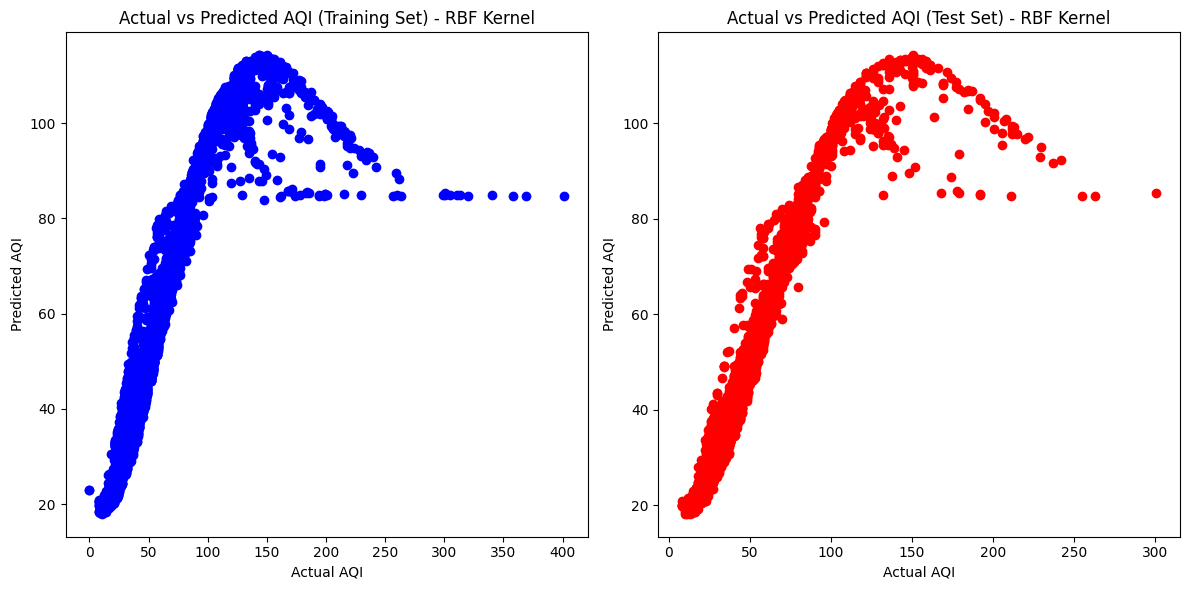

In [79]:
# Plot actual vs predicted AQI values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred_rbf, color='blue')
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.title('Actual vs Predicted AQI (Training Set) - RBF Kernel')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred_rbf, color='red')
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.title('Actual vs Predicted AQI (Test Set) - RBF Kernel')

plt.tight_layout()
plt.show()

In [80]:
# Define custom scoring functions
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

# Perform cross-validation for MSE
cv_scores_rbf_mse = cross_val_score(svr_rbf_seoul, X_top_features, y, cv=5, scoring=mse_scorer)
cv_mse_rbf = -cv_scores_rbf_mse.mean()  # Negate the result to get positive MSE
cv_rmse_rbf = np.sqrt(cv_mse_rbf)

# Perform cross-validation for R^2
cv_scores_rbf_r2 = cross_val_score(svr_rbf_seoul, X_top_features, y, cv=5, scoring=r2_scorer)
cv_r2_rbf = cv_scores_rbf_r2.mean()

print("Cross-Validation Results for SVR with RBF Kernel")
print(f"Mean Squared Error (MSE): {cv_mse_rbf}")
print(f"Root Mean Squared Error (RMSE): {cv_rmse_rbf}")
print(f"R^2 Score: {cv_r2_rbf}")


Cross-Validation Results for SVR with RBF Kernel
Mean Squared Error (MSE): 128.76540932766494
Root Mean Squared Error (RMSE): 11.34748471370043
R^2 Score: 0.8270062728614725


In [81]:
def compare_y_test_y_pred(y_test, y_predicted):

  comparison_df = pd.DataFrame({'actual': y_test, 'predicted': y_test_pred_rbf})
  comparison_df['error'] = comparison_df['predicted'] - comparison_df['actual']
  return comparison_df

comparison_df_rbf = compare_y_test_y_pred(y_test, y_test_pred_rbf)
print(comparison_df_rbf)

       actual  predicted     error
196      63.0  65.101498  2.101498
14441    48.0  45.508824 -2.491176
16532    42.0  39.421678 -2.578322
13719    40.0  40.467616  0.467616
24116    54.0  54.120773  0.120773
...       ...        ...       ...
24396    31.0  37.222022  6.222022
20437    48.0  53.055712  5.055712
15946    16.0  21.220536  5.220536
23702    44.0  47.829305  3.829305
6007     67.0  67.407186  0.407186

[7762 rows x 3 columns]


Text(0.5, 1.0, 'Error Distribution')

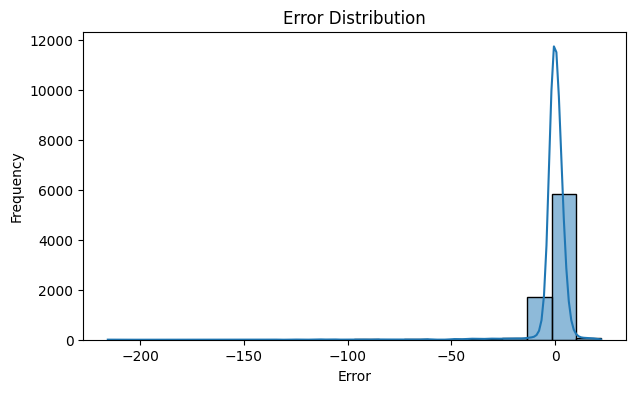

In [82]:
# 2. Error Distribution
plt.figure(figsize=(7, 4))
sns.histplot(comparison_df_rbf['error'], bins=20, kde=True)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Error Distribution')

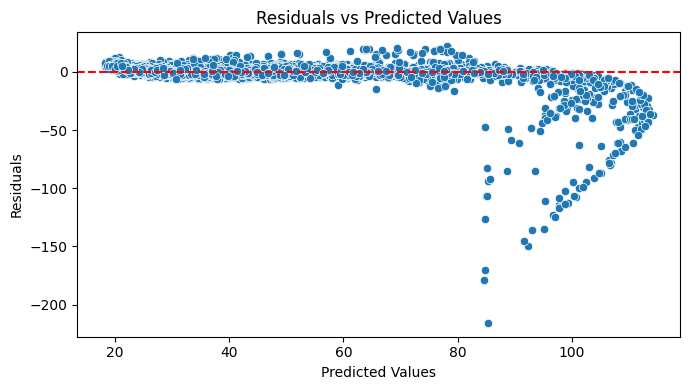

In [83]:
# 3. Residual Plot
plt.figure(figsize=(7, 4))
sns.scatterplot(x=comparison_df_rbf['predicted'], y=comparison_df_rbf['error'])
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.axhline(y=0, color='r', linestyle='--')

plt.tight_layout()
plt.show()